In [1]:
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
import os
import scipy
import hdf5storage
import json
from collections import Counter

from feature_selection import feature_selection, HDA, epiScanpy, Signac
from tool import *

# Read Data

In [2]:
select_num = 20000
seed_base = 2
filter_para = 0.01

In [3]:
print('load dataset...')
file_path = '../data'
ATAC_count = np.load(file_path + '/atac_count.npz')['arr_0']
with open(file_path + '/atac.json','r',encoding='utf8') as fp:
    ATAC = json.load(fp)
label = ATAC['cell_name']
peaks = []
for peak in ATAC['peak_name']:
    peaks.append(peak[0]+'_'+peak[1]+'_'+peak[2])
peaks = np.array(peaks)
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count))
ATAC_all.obs['label'] = ATAC['cell_name']
ATAC_all.var_names = peaks
ATAC_all

load dataset...


AnnData object with n_obs × n_vars = 6431 × 436177
    obs: 'label'

In [4]:
Counter(ATAC_all.obs['label'])

Counter({'Hematopoietic progenitors': 5,
         'Unknown': 313,
         'Proximal tubule': 2565,
         'Proximal tubule S3': 594,
         'T cells': 18,
         'Regulatory T cells': 8,
         'NK cells': 3,
         'Sperm': 1,
         'B cells': 27,
         'Macrophages': 50,
         'Dendritic cells': 13,
         'Alveolar macrophages': 1,
         'Collisions': 1,
         'DCT/CD': 499,
         'Loop of henle': 814,
         'Distal convoluted tubule': 319,
         'Collecting duct': 164,
         'Endothelial I cells': 24,
         'Endothelial I (glomerular)': 534,
         'Endothelial II cells': 15,
         'Monocytes': 3,
         'Podocytes': 447,
         'Type II pneumocytes': 1,
         'Hepatocytes': 1,
         'Activated B cells': 10,
         'Enterocytes': 1})

In [5]:
# Cell types that contain more than 50 cells.
idx = (ATAC_all.obs['label'] == 'Unknown') | (ATAC_all.obs['label'] == 'Proximal tubule') | (ATAC_all.obs['label'] == 'Proximal tubule S3') | (ATAC_all.obs['label'] == 'Proximal tubule S3') | (ATAC_all.obs['label'] == 'DCT/CD') | (ATAC_all.obs['label'] == 'Loop of henle') | (ATAC_all.obs['label'] == 'Distal convoluted tubule') | (ATAC_all.obs['label'] == 'Collecting duct') | (ATAC_all.obs['label'] == 'Endothelial I (glomerular)') | (ATAC_all.obs['label'] == 'Endothelial I (glomerular)')
ATAC_all = ATAC_all[idx,:]
ATAC_all

View of AnnData object with n_obs × n_vars = 5802 × 436177
    obs: 'label'

# Feature Selection

In [6]:
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, select_num, seed_base, filter_para)

View of AnnData object with n_obs × n_vars = 5802 × 436177
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 5802 × 112562
    obs: 'label'
(112562, 100)
processing...0/112562 0%
processing...10000/112562 8%
processing...20000/112562 17%
processing...30000/112562 26%
processing...40000/112562 35%
processing...50000/112562 44%
processing...60000/112562 53%
processing...70000/112562 62%
processing...80000/112562 71%
processing...90000/112562 79%
processing...100000/112562 88%
processing...110000/112562 97%
processing...112562/112562 100%
First fitting.
Second fitting.
Third fitting.


# Evaluation

## Evaluate by cell clustering

In [7]:
print('After selecting peaks, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = list(ATAC_all.obs['label'])

sc.pp.neighbors(ATAC_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
louvain_df = run_louvain(ATAC_pca,'label','cluster',seed=int(seed_base*1000))
print("cluster results:")
print(louvain_df)
ATAC_pca.obsm['latent'] = scipy.sparse.csc_matrix(ATAC_count_filter)
print("ASW:")
print(silhouette(adata=ATAC_pca, group_key='label', embed='latent'))
ATAC_pca.obsm['X_emb'] = scipy.sparse.csc_matrix(ATAC_count_filter)
ATAC_pca.obs['label'] = ATAC_pca.obs['label'].astype('category')
print("cLISI:")
print(clisi_graph(adata=ATAC_pca, label_key='label', type_='embed'))

After selecting peaks, the matrix dimensions are reduced to (5802, 20000)


After PCA, the matrix dimensions are reduced to (5802, 10)
Clustering...
resolution: 0.1, NMI: 0.5956855918636454, ARI: 0.4180996663381168, Homo: 0.5193941165431463, AMI: 0.595195093830432
resolution: 0.2, NMI: 0.6723524005874206, ARI: 0.5100185081753734, Homo: 0.6297132189936013, AMI: 0.6718586771044469
resolution: 0.3, NMI: 0.6743048260997235, ARI: 0.5229614838894111, Homo: 0.688837564316639, AMI: 0.6736262343002589
resolution: 0.4, NMI: 0.6808626074831248, ARI: 0.5256850142236085, Homo: 0.729081479070979, AMI: 0.6801243741095085
resolution: 0.5, NMI: 0.6294932248338128, ARI: 0.3692181838948442, Homo: 0.7286995997852752, AMI: 0.6284731178328724
resolution: 0.6, NMI: 0.617318031851978, ARI: 0.3468604178856868, Homo: 0.7533896384537911, AMI: 0.6159799558613829
resolution: 0.7, NMI: 0.6029634950041078, ARI: 0.32882993740531485, Homo: 0.7389527436520554, AMI: 0.6015827230713312
resolution: 0.8, NMI: 0.6059391088320858, ARI: 0.3309924919252444, Homo: 0.7680551949957135, AMI: 0.60427418818

## UMAP

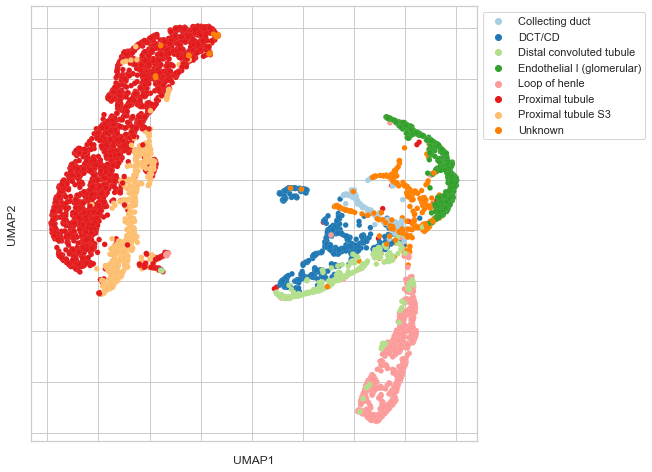

In [8]:
# umap
sns.set_theme(style='whitegrid')
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
a = np.unique(df['label'])
palet = sns.color_palette("Paired",a.shape[0])
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label", palette=palet, s=30,linewidth = 0.05, data=df)
ax.legend(bbox_to_anchor=(1,1))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()